# Image Feature Extraction with a Restricted Boltzmann Machine

The [Yale Face Database](http://vision.ucsd.edu/content/yale-face-database) contains 165 grayscale images in GIF format of 15 individuals. There are 11 images per subject, one per different facial expression or configuration: center-light, w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink.

Also credit to the creators of [this normalized version](http://vismod.media.mit.edu/vismod/classes/mas622-00/datasets/) of this dataset. The Centered versions of the images are what are used in the below analysis. 

In the following analysis I will use a **Restricted Boltzmann Machine (RBM)** to generate features and test their viability in classifying the 15 different subjects. 

In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

from sklearn.neural_network import BernoulliRBM
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics

from skimage.transform import resize
from skimage.io import imread_collection, imshow

In [2]:
#Read in all centered images, and examine the size of the first image
imgs = imread_collection('centered/*.gif')
print("Imported", len(imgs), "images")
print("The first one is",len(imgs[0]), "pixels tall, and",
     len(imgs[0][0]), "pixels wide")

Imported 165 images
The first one is 231 pixels tall, and 195 pixels wide


In [3]:
#Let's confirm that they're all the same size:
print(np.std([len(x) for x in imgs]))
print(np.std([len(x[0]) for x in imgs]))

0.0
0.0


# Examples of Images

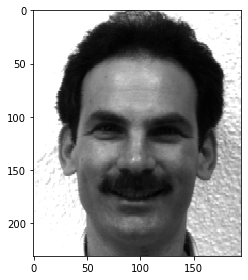

In [4]:
#Example of Happy
imshow(imgs[13])

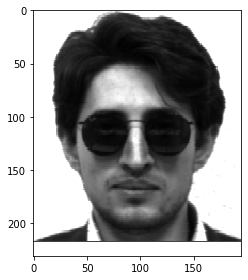

In [5]:
#Example of Glasses
imshow(imgs[23])

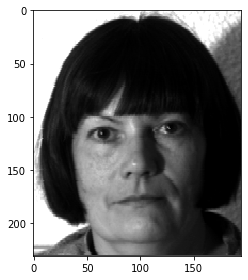

In [6]:
#Example of shading
imshow(imgs[113])

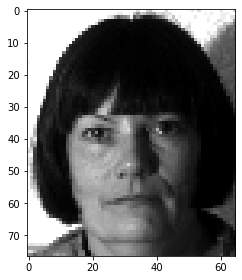

In [7]:
#Let's resize; at this 231x165, the RBM may have memory issues.
#this reduces our image vectors from length of 38,115 (231x165)
#to length of 5,005 (77x65), significantly improving performance

imgs = [resize(x,(77,65),mode='constant', anti_aliasing=False) for x in imgs]

#Show an example of a reduced image
imshow(imgs[113])

In [8]:
#Flatten all images to arrays
imgsarr = [x.flatten('C') for x in imgs]

# Goal
Use RBM to perform feature extraction on these images, and examine the features.

In [9]:
#Create a target variable: 1 through 15 for each of the 15 subjects
Y = [[_ for i in range(1,12)] for _ in range(1,16)]
Y = [num for sub in Y for num in sub]

In [10]:
#Define the RBM, used for feature generation
rbm = BernoulliRBM(random_state=0, verbose=True, learning_rate=.01,
                  n_iter=20, n_components=150)

#Define the Classifier - Logistic Regression will be used in this case
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              C=6000, multi_class='multinomial')

#Combine the two into a Pipeline
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

In [11]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(imgsarr, Y)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2859.07, time = 0.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -3044.42, time = 0.38s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2666.64, time = 0.38s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2527.39, time = 0.39s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2475.21, time = 0.37s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2468.15, time = 0.36s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2482.79, time = 0.34s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2466.78, time = 0.35s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2459.73, time = 0.35s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2439.38, time = 0.36s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2472.59, time = 0.36s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2449.64, time = 0.39s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2411.27, time = 0.35s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2447.42, time = 0.35s
[

Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.01, n_components=150, n_iter=20,
                              random_state=0, verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, max_iter=10000,
                                    multi_class='multinomial'))])

In [12]:
#Confirm success by predicting the training data
Y_pred = rbm_features_classifier.predict(imgsarr)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        11
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        11
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00        11

    accuracy                           1.00       165
   macro avg       1.00      1.00      1

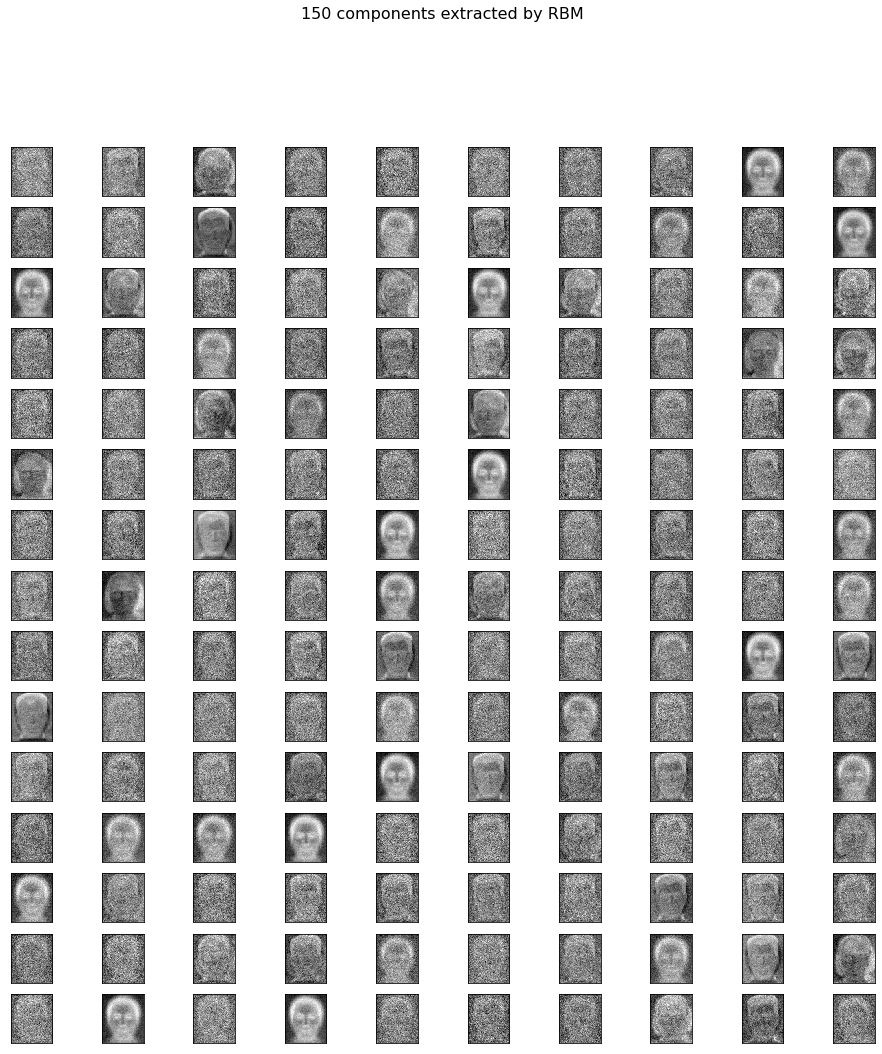

In [13]:
#Let's view the 150 components created by the RBM

plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_[:150]):
    plt.subplot(15, 10, i + 1)
    plt.imshow(comp.reshape((77, 65)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('150 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

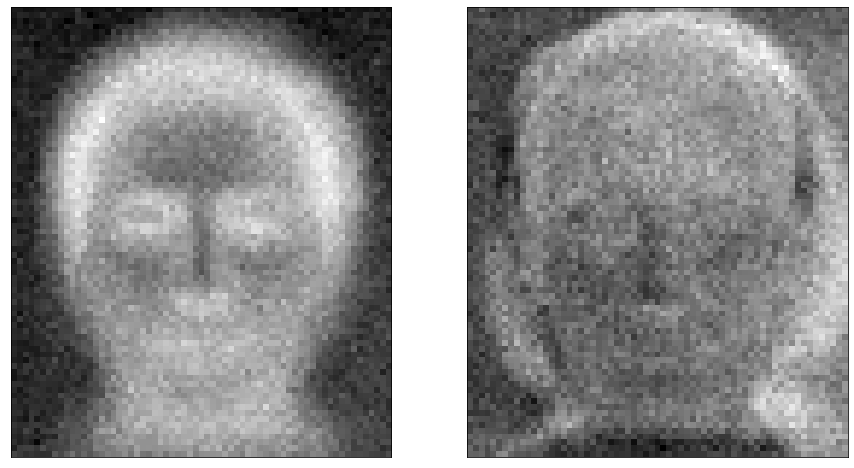

In [14]:
#Selected features for closer examination
first = 8
second = 45

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(rbm.components_[first].reshape((77, 65)), cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.xticks(())
plt.yticks(())
plt.subplot(122)
plt.imshow(rbm.components_[second].reshape((77, 65)), cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.xticks(())
plt.yticks(())
plt.show()

# Let's try adding 5x more data by creating copies of these images shifted a pixel in each direction
Function credit to [scikit-learn](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html#sphx-glr-auto-examples-neural-networks-plot-rbm-logistic-classification-py)

In [15]:
def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 77x65 images in X around by 1px to left, right, down, up
    Credit to SciKitLearn (linked above)
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((77, 65)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [16]:
X = np.asarray(imgsarr, 'float32')
Xbig, Ybig = nudge_dataset(X, Y)

In [17]:
#Redefine the RBM
rbm = BernoulliRBM(random_state=0, verbose=True, learning_rate=.01,
                  n_iter=20, n_components=150)

#Redefine the Logistic Classifier
logistic = LogisticRegression(solver='lbfgs', max_iter=10000,
                              C=6000, multi_class='multinomial')

#Combine the two into a Pipeline
rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

rbm_features_classifier.fit(Xbig, Ybig)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -2835.24, time = 1.69s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -2534.00, time = 1.81s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -2518.91, time = 1.81s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -2493.52, time = 1.74s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -2468.01, time = 1.73s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2442.06, time = 1.66s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2414.09, time = 1.68s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -2385.61, time = 1.73s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -2342.01, time = 1.68s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2337.42, time = 1.76s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2304.77, time = 1.74s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2317.01, time = 1.73s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2307.05, time = 1.71s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2245.47, time = 1.65s
[

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(steps=[('rbm',
                 BernoulliRBM(learning_rate=0.01, n_components=150, n_iter=20,
                              random_state=0, verbose=True)),
                ('logistic',
                 LogisticRegression(C=6000, max_iter=10000,
                                    multi_class='multinomial'))])

In [18]:
Y_pred = rbm_features_classifier.predict(Xbig)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Ybig, Y_pred)))

Logistic regression using RBM features:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        55
           2       1.00      1.00      1.00        55
           3       1.00      0.98      0.99        55
           4       0.98      1.00      0.99        55
           5       1.00      1.00      1.00        55
           6       1.00      1.00      1.00        55
           7       1.00      1.00      1.00        55
           8       1.00      0.98      0.99        55
           9       1.00      1.00      1.00        55
          10       1.00      1.00      1.00        55
          11       1.00      1.00      1.00        55
          12       1.00      1.00      1.00        55
          13       1.00      1.00      1.00        55
          14       0.98      1.00      0.99        55
          15       1.00      1.00      1.00        55

    accuracy                           1.00       825
   macro avg       1.00      1.00      1

## With the Added Data and 150 components, this pipeline has predicted the training data perfectly.
Note that it's probably overfit and this is not ideal for new data, but it is for our goal of examining the components a RBM can extract.

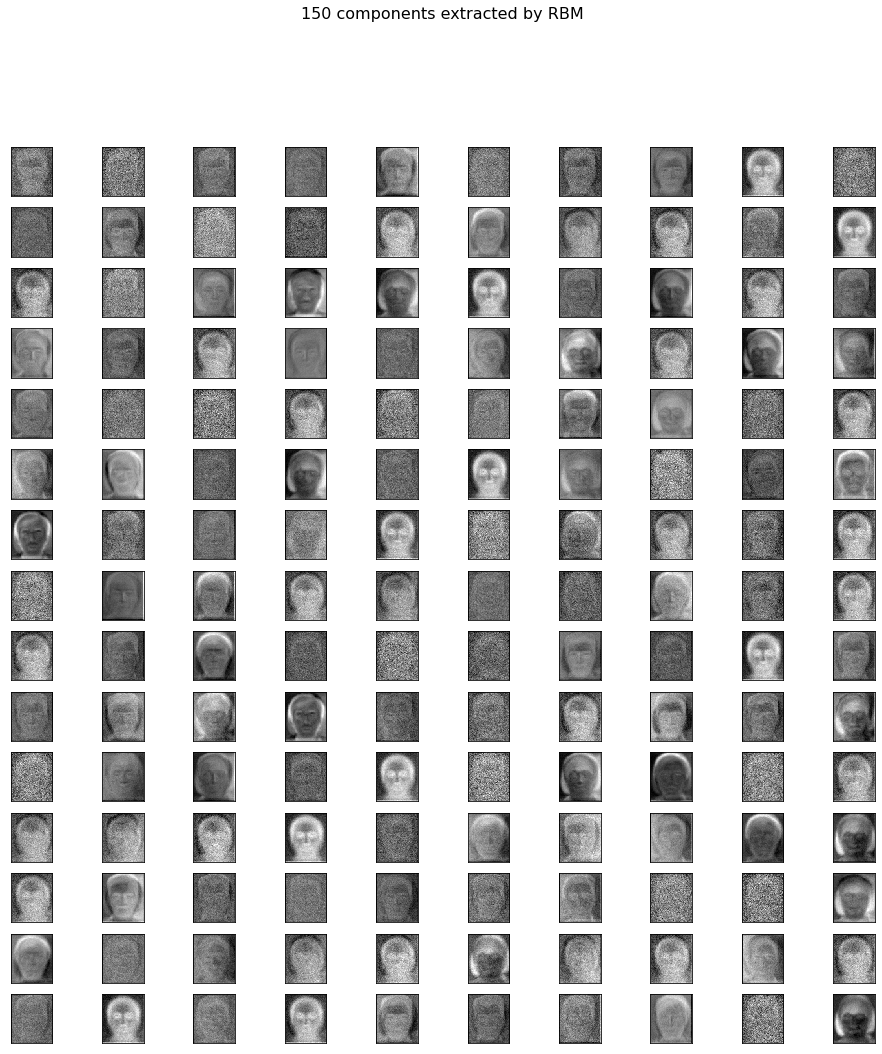

In [19]:
#Components for examination
plt.figure(figsize=(15, 15))
for i, comp in enumerate(rbm.components_):
    plt.subplot(15, 10, i + 1)
    plt.imshow(comp.reshape((77, 65)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('150 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

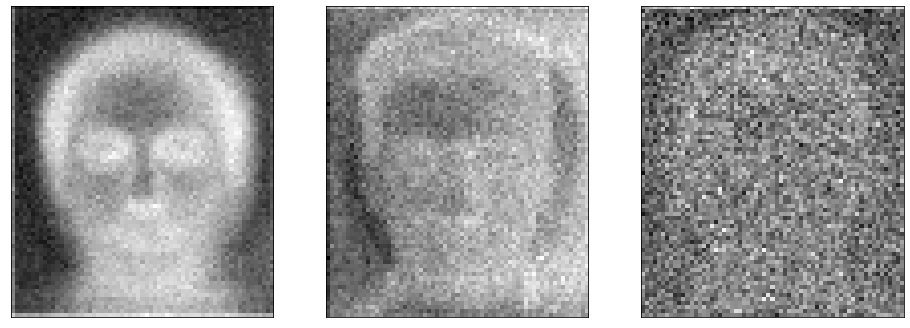

In [20]:
#Selected features for closer examination
toshow = [104,116,84]

plt.figure(figsize=(16, 10))
for i, comp in enumerate(toshow):
    plt.subplot(1,3,i+1)
    plt.imshow(rbm.components_[comp].reshape((77, 65)), cmap=plt.cm.gray_r,
           interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.show()

# Analysis

For some hidden components, like the left and center examples above, it's intuitive to see how they are storing information about image content, and how they contribute to recreations of the original (during fitting) or predictions. Others, like the right, are less so. This is not an indication of usefuleness; even if a hidden component is not intuitively explaining patterns to the human eye, it can combine with other hidden components to make accurate predictions.